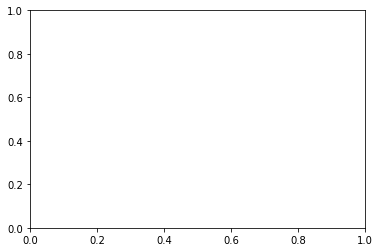

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import neon_aop_refl_hdf5_functions as hdf5
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd
import pickle
import sys
import os
import datetime
import dateutil.parser
from datetime import timedelta
import itertools
from tqdm import tqdm_notebook as tqdm
import enum
import copy
from ipyleaflet import Map, WMSLayer
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam, WmsRequest, WcsRequest, MimeType


In [2]:
INSTANCE_ID = 'adba8367-072c-48e8-ae71-cd60dc00ac64'
clipExtDict = {}
clipExtDict['xMin'] = 367400.
clipExtDict['xMax'] = 368100.
clipExtDict['yMin'] = 4305750.
clipExtDict['yMax'] = 4306350.

clipExtent = (clipExtDict['xMin'],clipExtDict['xMax'],clipExtDict['yMin'],clipExtDict['yMax'])

In [3]:
rand_test = Map(center = [-25.81, 28.02], zoom = 14) #map viewer

In [4]:
def plot_image(image, factor=1):
    """
    helper to visualize tiles
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)
def calc_NDVI(bands_request, select):
    #select = the index of the farm (all requests will return an array of images of the same farm ordered by date)
    eight = np.asarray((bands_request[select][:, :, 8]).astype(float))
    four = np.asarray((bands_request[select][:, :, 4]).astype(float))
    #ndvi = eight -four /eight + four
    ndvi = np.divide((eight-four), (eight + four)).astype(float)
    return ndvi
def processDate(date):
    day = str(date.day)
    month = str(date.month)
    if int(day) < 10:
        day = '0' + day
    if int(month) < 10:
        month = '0' + month 
    return str(date.year) + "-" + month+ "-" + day
def makeRange(date1, width): #helper method for automation of date processing
    convert = datetime.datetime.strptime(date1,"%Y-%m-%dT%H:%M:%S.%fZ")
    datepre = convert - timedelta(days = 3)
    dateafter = convert + timedelta(days = width)
    return (processDate(datepre), processDate(dateafter))

def makeBbox(lat, lon): #helper method for automation of bbox processing
    farm = [-.006 + lon, -.004 + lat, .006 + lon,   .004 + lat]
    return  BBox(bbox=farm, crs=CRS.WGS84)

In [5]:
unp2_dateTime = "2018-09-19T11:25:31.000Z"

t_delta = 25
reported_range = makeRange(unp2_dateTime, 15)

before_date = '{:%Y-%m-%dT%H:%M:%S.%fZ}'.format(datetime.datetime.strptime(unp2_dateTime,"%Y-%m-%dT%H:%M:%S.%fZ") - timedelta(t_delta))
before_range = makeRange(before_date,15)

after_date = '{:%Y-%m-%dT%H:%M:%S.%fZ}'.format(datetime.datetime.strptime(unp2_dateTime,"%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(t_delta))
after_range = makeRange(after_date,15)


In [6]:
lon = 34.0683307
lat= 18.1003292
farm_bbox = makeBbox(lat, lon)


In [7]:
reported_range

('2018-09-16', '2018-10-04')

These 3 images were taken on the following dates:
 - image 0 was taken on 2018-09-20 08:22:03
 - image 1 was taken on 2018-09-25 08:22:52
 - image 2 was taken on 2018-09-30 08:14:25
rgb output of the farm


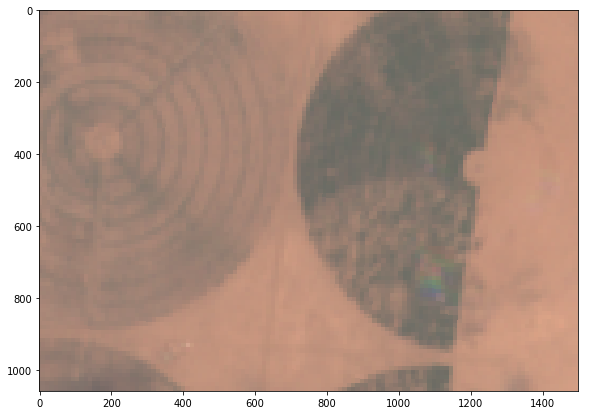

In [8]:
#DATE REPORTED
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox= farm_bbox,
                                    time= reported_range,
                                    
                                    width= 1500,
                                    # maxcc = .1,
                                    instance_id=INSTANCE_ID,
                                   time_difference=datetime.timedelta(hours=4))
wms_true_color_img = wms_true_color_request.get_data() 
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))


print("rgb output of the farm")
plot_image(wms_true_color_img[0])

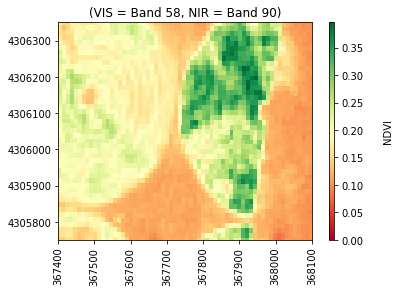

In [9]:
#DATE REPORTED NDVI VIEW
wms_bands_request = WmsRequest(layer='BANDS-S2-L1C',
                               bbox= farm_bbox, 
                               time= reported_range,
                               width=1500, 
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID,
                              time_difference=datetime.timedelta(hours=8))
wms_bands_img = wms_bands_request.get_data()
ndvi = calc_NDVI(wms_bands_img,0)

hdf5.plot_band_array(ndvi,clipExtent,(0,np.max(ndvi)),title='(VIS = Band 58, NIR = Band 90)',cmap_title='NDVI',colormap='RdYlGn')

In [10]:
print(t_delta)
before_range

25


('2018-08-22', '2018-09-09')

These 3 images were taken on the following dates:
 - image 0 was taken on 2018-08-26 08:18:20
 - image 1 was taken on 2018-08-31 08:22:43
 - image 2 was taken on 2018-09-05 08:16:28


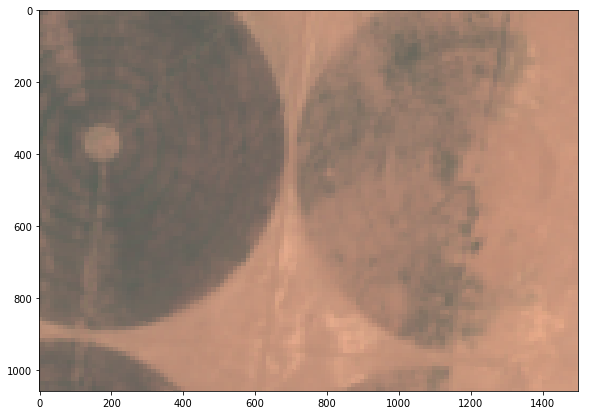

In [11]:
#RGB farm t_delta before the report
wms_true_color_request2 = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox= farm_bbox,
                                    time= before_range,
                                    
                                    width= 1500,
                                    #maxcc = .3,
                                    instance_id=INSTANCE_ID,
                                   time_difference=datetime.timedelta(hours=4))
wms_true_color_img2 = wms_true_color_request2.get_data() 
print('These %d images were taken on the following dates:' % len(wms_true_color_img2))
for index, date in enumerate(wms_true_color_request2.get_dates()):
    print(' - image %d was taken on %s' % (index, date))
plot_image(wms_true_color_img2[0])

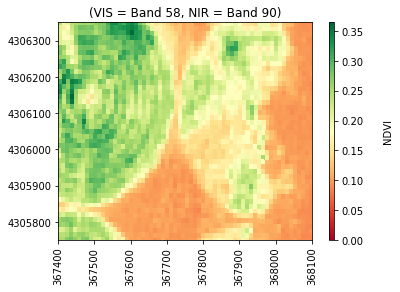

In [12]:
#NDVI before the report
wms_bands_request2 = WmsRequest(layer='BANDS-S2-L1C',
                               bbox= farm_bbox, 
                               time= before_range,
                               width= 1500, 
                               
                                #maxcc = .1,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID,
                                
                              time_difference=datetime.timedelta(hours=8))
wms_bands_img2 = wms_bands_request2.get_data()
ndvi2 = calc_NDVI(wms_bands_img2, 0)
hdf5.plot_band_array(ndvi2,clipExtent,(0,np.max(ndvi2)),title='(VIS = Band 58, NIR = Band 90)',cmap_title='NDVI',colormap='RdYlGn')

In [13]:
print(t_delta)
after_range

25


('2018-10-11', '2018-10-29')

These 3 images were taken on the following dates:
 - image 0 was taken on 2018-10-15 08:14:17
 - image 1 was taken on 2018-10-20 08:18:30
 - image 2 was taken on 2018-10-25 08:21:05


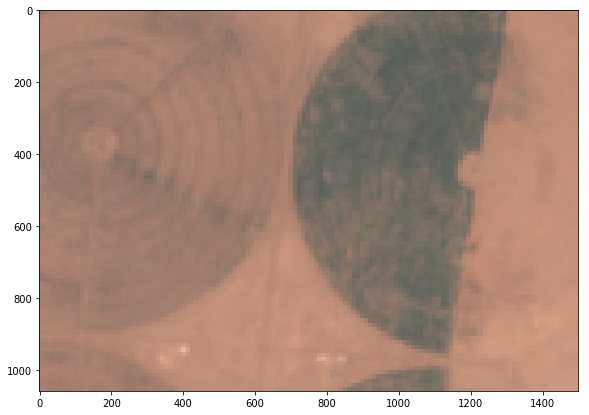

In [14]:
#RGB farm t_delta after the report
wms_true_color_request2 = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox= farm_bbox,
                                    time= after_range,
                                    
                                    width= 1500,
                                    #maxcc = .3,
                                    instance_id=INSTANCE_ID,
                                   time_difference=datetime.timedelta(hours=4))
wms_true_color_img2 = wms_true_color_request2.get_data() 
print('These %d images were taken on the following dates:' % len(wms_true_color_img2))
for index, date in enumerate(wms_true_color_request2.get_dates()):
    print(' - image %d was taken on %s' % (index, date))
plot_image(wms_true_color_img2[0])

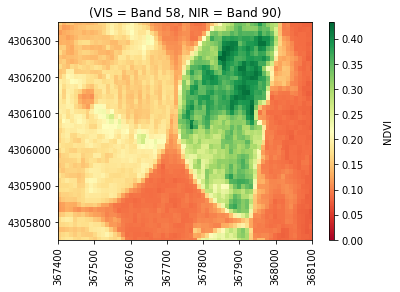

In [15]:
#NDVI after the report
wms_bands_request2 = WmsRequest(layer='BANDS-S2-L1C',
                               bbox= farm_bbox, 
                               time= after_range,
                               width= 1500, 
                               
                                #maxcc = .1,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID,
                                
                               time_difference=datetime.timedelta(hours=8))
wms_bands_img2 = wms_bands_request2.get_data()
ndvi3 = calc_NDVI(wms_bands_img2, 0)
hdf5.plot_band_array(ndvi3,clipExtent,(0,np.max(ndvi3)),title='(VIS = Band 58, NIR = Band 90)',cmap_title='NDVI',colormap='RdYlGn')

In [16]:
threshold = .2

Mean NDVI > 0.6: 0.26


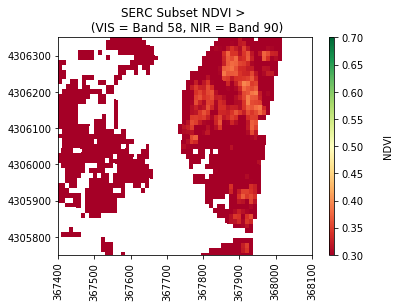

In [17]:
#spectra data for DURING image
#extract spectra code by removing values that are below the ndvi threshold

ndvi_gtpt61 = copy.copy(ndvi)
ndvi_gtpt61[ndvi< threshold] = np.nan  #set all pixels with NDVI <  to nan, keeping only values > 
spectra_mean1 = np.nanmean(ndvi_gtpt61)
print('Mean NDVI > 0.6:',round(np.nanmean(ndvi_gtpt61),2))

hdf5.plot_band_array(ndvi_gtpt61,clipExtent,(0.3,.7),title='SERC Subset NDVI > \n (VIS = Band 58, NIR = Band 90)',
                cmap_title='NDVI',colormap='RdYlGn')

Mean NDVI > 0.6: 0.25


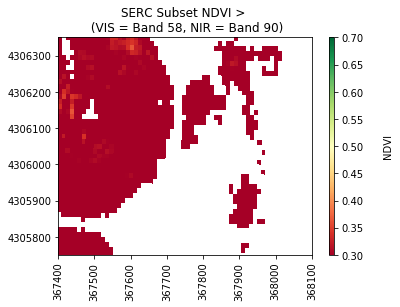

In [18]:
#spectra data for AFTER image
#extract spectra code by removing values that are below the ndvi threshold


ndvi_gtpt62 = copy.copy(ndvi2)
ndvi_gtpt62[ndvi2< threshold] = np.nan  #set all pixels with NDVI <  to nan, keeping only values > 
spectra_mean2 = np.nanmean(ndvi_gtpt62)
print('Mean NDVI > 0.6:',round(np.nanmean(ndvi_gtpt62),2))

hdf5.plot_band_array(ndvi_gtpt62,clipExtent,(0.3,.7),title='SERC Subset NDVI > \n (VIS = Band 58, NIR = Band 90)',
                cmap_title='NDVI',colormap='RdYlGn')

Mean NDVI > 0.6: 0.32


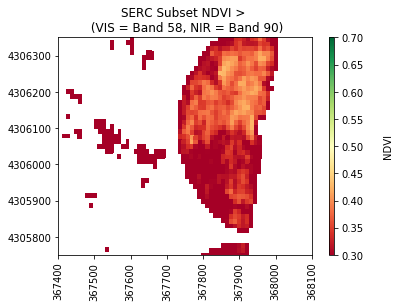

In [19]:
#spectra data for AFTER image
#extract spectra code by removing values that are below the ndvi threshold


ndvi_gtpt63 = copy.copy(ndvi3)
ndvi_gtpt63[ndvi3< threshold] = np.nan  #set all pixels with NDVI <  to nan, keeping only values > 
spectra_mean3 = np.nanmean(ndvi_gtpt63)
print('Mean NDVI > 0.6:',round(np.nanmean(ndvi_gtpt63),2))

hdf5.plot_band_array(ndvi_gtpt63,clipExtent,(0.3,.7),title='SERC Subset NDVI > \n (VIS = Band 58, NIR = Band 90)',
                cmap_title='NDVI',colormap='RdYlGn')